#### Set up Dataset - A binary subset of CIFAR 10

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import DenseNet121, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from movies.inference import load_model

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a binary subset for classes 'cat' (label 3) and 'dog' (label 5)
binary_classes = [3, 5]
train_filter = np.isin(y_train, binary_classes).reshape(-1)
test_filter = np.isin(y_test, binary_classes).reshape(-1)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Map labels to binary (0 and 1)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Resize images to match input size for pretrained models (224x224)
IMG_SIZE = (224, 224)

# Resizing function for CIFAR-10 images
def preprocess_images(images):
    return np.array([tf.image.resize(image, IMG_SIZE).numpy() for image in images])

x_train_resized = preprocess_images(x_train)
x_test_resized = preprocess_images(x_test)


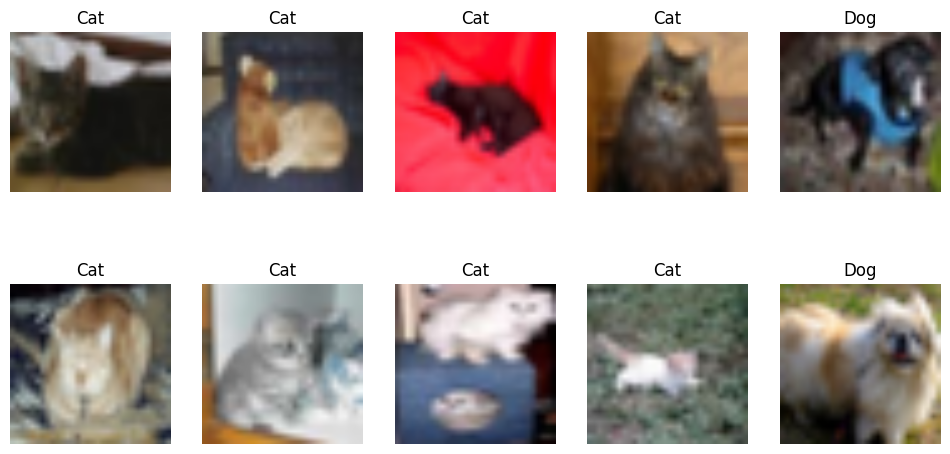

In [5]:
# Define class names for display
class_names = ["Cat", "Dog"]

# Function to display sample images
def display_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[labels[i][0]])
        plt.axis("off")
    plt.show()

# Display 10 sample images from the resized training dataset
display_sample_images(x_train_resized, y_train, class_names, num_images=10)


In [4]:
x_train_resized.shape

(10000, 224, 224, 3)

#### Preprocessing and Augmentation

In [7]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow(x_train_resized, y_train, batch_size=32)
test_gen = test_datagen.flow(x_test_resized, y_test, batch_size=32)

#### Creating Models
* DenseNet121
* VGG16
* InceptionResNetV2

In [6]:
def create_model(base_model_class, input_shape=(224, 224, 3)):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialize models
densenet_model = create_model(DenseNet121)
vgg_model = create_model(VGG16)
inception_resnet_model = create_model(InceptionResNetV2)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


#### Define Validation Set and all Models

In [11]:
# Danger cell
epochs = 50
learning_rate = 1e-4
patience = 5

# Adjust the train ImageDataGenerator to include a validation split
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Create train and validation generators from the same train directory
train_gen = train_datagen.flow(x_train_resized, y_train, subset='training', batch_size=32)
val_gen = train_datagen.flow(x_train_resized, y_train, subset='validation', batch_size=32)

# Updated compile_and_train function to use val_gen
def compile_and_train(model, train_gen, val_gen, epochs, learning_rate, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

# Train each model and collect histories using the validation split
densenet_history = compile_and_train(densenet_model, train_gen, val_gen, epochs, learning_rate, 'DenseNet121')
vgg_history = compile_and_train(vgg_model, train_gen, val_gen, epochs, learning_rate, 'VGG16')
inception_resnet_history = compile_and_train(inception_resnet_model, train_gen, val_gen, epochs, learning_rate, 'InceptionResNetV2')


#### Learning Curves

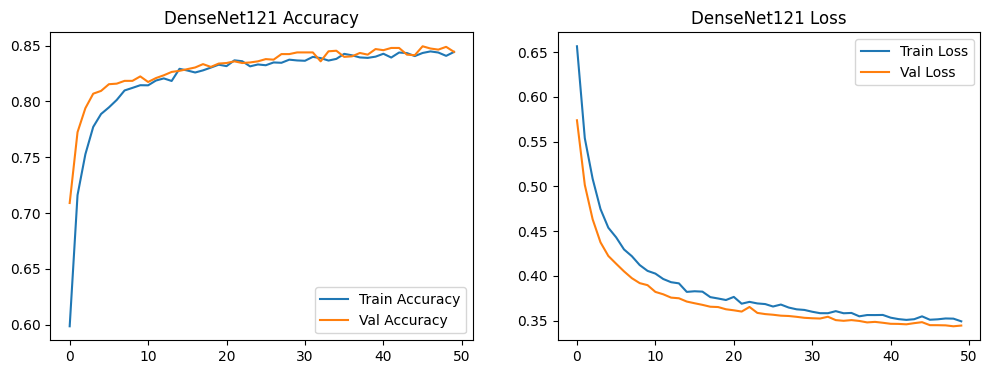

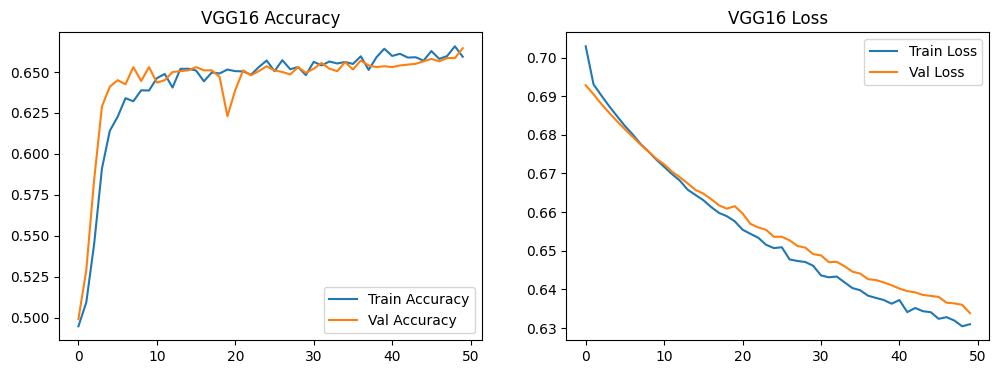

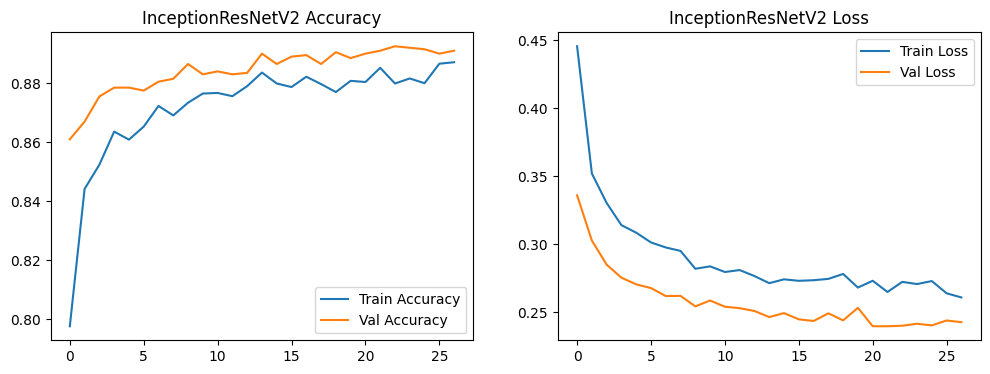

In [8]:
# Plot function for learning curves
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.legend()

    plt.show()

# Display learning curves for each model
plot_learning_curves(densenet_history, 'DenseNet121')
plot_learning_curves(vgg_history, 'VGG16')
plot_learning_curves(inception_resnet_history, 'InceptionResNetV2')


#### Fine Tuning

In [16]:
densenet_model = load_model('DenseNet121_best_model.keras')
vgg_model = load_model('VGG16_best_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Nadam

# Load the saved model
inception_resnet_model = load_model('InceptionResNetV2_best_model.keras')

# Define new training parameters
reduced_learning_rate = 1e-5  # Reduced learning rate for continued training
new_optimizer = Nadam(learning_rate=reduced_learning_rate)  # New optimizer

# Compile and train the loaded model with updated settings
def continue_training(model, train_gen, val_gen, epochs, optimizer, model_name):
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_fine_tuned_best_model.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

# Continue training the model with new optimizer and settings
fine_tuned_history = continue_training(inception_resnet_model, train_gen, val_gen, epochs=15, optimizer=new_optimizer, model_name='InceptionResNetV2')


#### Evaluation on separate Test Set

In [20]:
# Function to calculate evaluation metrics and format results
def get_evaluation_metrics(model, test_gen, name):
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
    return {'Model': name, 'Test Loss': test_loss, 'Test Accuracy': test_accuracy}

# List of models to evaluate with their names
models_to_evaluate = [
    (densenet_model, test_gen, 'DenseNet121'),
    (vgg_model, test_gen, 'VGG16'),
    (inception_resnet_model, test_gen, 'InceptionResNetV2')
]

# Evaluate each model and collect metrics
evaluation_results = [get_evaluation_metrics(model, test_gen, name) for model, test_gen, name in models_to_evaluate]


In [21]:
import pandas as pd
# Convert results to a DataFrame and display
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

               Model  Test Loss  Test Accuracy
0        DenseNet121   0.327408       0.854250
1              VGG16   0.632666       0.664750
2  InceptionResNetV2   0.232922       0.903375
